In [1]:
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import usphere_utils as uu

In [3]:
## make some job files
num_per_chunk = 1e7
nmc_zero_mass = 1e10
nmc_nonzero_mass = 1e8
num_reps_per_file = 100

iso_list = ["p_32",] #"ar_37", "be_7", "v_49", "cr_51", "fe_55", "ge_68", "se_72"]

dsq_file = "/Users/dcmoore/grace/impulse/steriles/dsq_jobs.sh"
dsqf = open(dsq_file, 'wt')
dsqf.write("#!/bin/bash\n")

for iso in iso_list:

    mnu = 0
    job_file = "/Users/dcmoore/grace/impulse/steriles/job_files/%s_jobs.txt"%iso
    jf = open(job_file, 'wt')
    nchunks = int(nmc_zero_mass/(num_reps_per_file*num_per_chunk))
    print(nchunks)
    for i in range(nchunks):
        jf.write("module load miniconda; source activate; conda activate py37_dev; python calculate_pdfs.py %s %.1f %d %d\n"%(iso, mnu, num_reps_per_file, i))
    jf.close()

    # 100 reps and 1e7 per chunk is 1.5 gb and 15 minutes
    dsqf.write("dsq --job-file job_files/%s_jobs.txt --mem-per-cpu 4g -t 30:00 --mail-type NONE\n"%iso)

    ## now for non zero masses
    job_file = "/Users/dcmoore/grace/impulse/steriles/job_files/%s_nonzero_jobs.txt"%iso
    jf = open(job_file, 'wt')
    num_reps_per_file = int(nmc_nonzero_mass/num_per_chunk)
    iso_dat = np.loadtxt("/Users/dcmoore/grace/impulse/steriles/data_files/%s.txt"%iso, delimiter=',', skiprows=3)
    Q, t12, A = iso_dat[0, :]
    ## now as a function of sterile mass
    mass_list = np.linspace(1, Q, 100)
    nmasses_per_file = 5
    nchunks = int(len(mass_list)/nmasses_per_file)
    for i in range(nchunks):
        curr_masses = mass_list[(i*nmasses_per_file):((i+1)*nmasses_per_file)]
        curr_str = ["%.1f"%j for j in curr_masses]
        mnu = ','.join(curr_str)
        jf.write("module load miniconda; source activate; conda activate py37_dev; python calculate_pdfs.py %s %s %d %d\n"%(iso, mnu, num_reps_per_file, 0))
    jf.close()

    # 10 reps x 5 masses and 1e7 per chunk is 1.5 gb and 7.5 minutes
    dsqf.write("dsq --job-file job_files/%s_nonzero_jobs.txt --mem-per-cpu 4g -t 30:00 --mail-type NONE\n"%iso)

dsqf.close()

10


In [7]:
iso = 'p_32'

of = open(save_dir + '%s_pdfs.pkl'%iso, 'rb')
pdfs = pickle.load(of)
of.close()


mass_list_str = pdfs.keys()
mass_list = []
for m in mass_list_str:
  cmass = float(m)
  if(cmass > 0):
    mass_list.append(cmass)

mass_list = sorted(mass_list)

ulim = np.ones_like(mass_list)*1e6

plt.figure()

bkg_pdf = pdfs['0.0']
levs = [0.0001,]

if( not iso in uu.beta_list):
  plt.semilogy(bkg_pdf[:,0], bkg_pdf[:,1], 'k')
else:
  x = bkg_pdf['x']
  p = bkg_pdf['p']
  p = p/np.sum(p)
  p[p==0] = np.nan
  p_orig = 1.0*p
  #plt.contour(x[:,0], x[:,1], p.T, levels=levs, colors='k')
  plt.pcolormesh(x[:,0], x[:,1], p.T)
  plt.colorbar()
  plt.title("$m_4 = 0$ keV")
  plt.xlabel("Measured electron kinetic energy [keV]")
  plt.ylabel(r"Reconstructed $\nu$ momentum [keV]")

plt.figure()
for i,m in enumerate(mass_list):
  sig_pdf = pdfs['%.1f'%m]

  if( not iso in uu.beta_list):
    plt.semilogy(sig_pdf[:,0], sig_pdf[:,1])
  else:
    x = sig_pdf['x']
    p = sig_pdf['p']
    p = p/np.sum(p)
    x = x[()] ## get the dict back from the 0d ndarray
    print(p)
    #plt.contour([x['bcx'], x['bcy']], p.T) #, levels=levs)
    p[p==0] = np.nan
    plt.pcolormesh(x[:,0], x[:,1], p.T)
    plt.colorbar()
    plt.contour(x[:,0], x[:,1], p_orig.T, levels=levs, colors='k')
    plt.title("$m_4 = %.1f$ keV"%m)
    plt.xlabel("Measured electron kinetic energy [keV]")
    plt.ylabel(r"Reconstructed $\nu$ momentum [keV]")

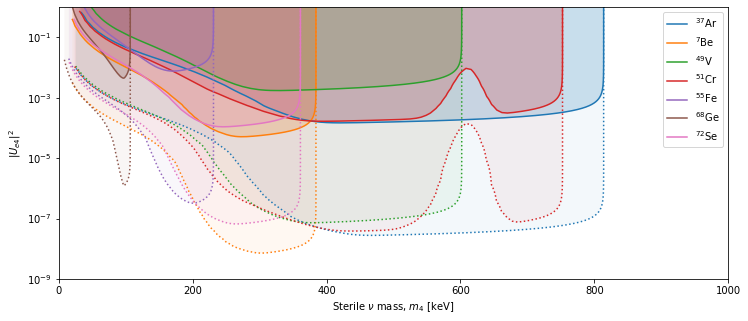

In [43]:
iso_list = ["ar_37", "be_7", "v_49", "cr_51", "fe_55", "ge_68", "se_72"]
isEC = True

fig=plt.figure()

for iso in iso_list:

    flist = glob.glob("/Users/dcmoore/grace/impulse/steriles/limits/%s*.npz"%iso)

    iso_dat = np.loadtxt("/Users/dcmoore/grace/impulse/steriles/data_files/%s.txt"%iso, delimiter=',', skiprows=3)
    Q, t12, A = iso_dat[0, :]

    for i,f in enumerate(flist):

        cdat = np.load(f)
        x = cdat['m']
        lim_vals = cdat['lim']
        
        good_vals = np.where(~(np.isnan(lim_vals)))[0] ## put to flat value at high mass (prior to phase space below)
        lim_vals[good_vals[-1]:] = lim_vals[good_vals[-1]]

        if(isEC):
            if(iso == "be_7"):
                Q = 384.22 ## hard code the gamma that gets subtracted
                           ## should fix this for general case (maybe do this in the limit step or pdf?)
            xfine = np.linspace(x[0], Q, 100000)
            limfine = np.interp(xfine, x, lim_vals, left=np.nan, right=np.nan)

            massfac = np.sqrt(1 - xfine**2/Q**2)
            Q_idx = np.argmin(np.abs(xfine - Q))
            massfac[Q_idx] = 1e-10
            limfine /= massfac

            ## trim any nans and maker sure plot reaches top
            g = ~np.isnan(limfine)
            xfine, limfine = xfine[g], limfine[g]
            xfine = np.append(xfine, xfine[-1]+1e-15)
            limfine = np.append(limfine, 1)

        if(i==0):
            p=plt.semilogy( xfine, limfine, ":" )
            c=p[0].get_color()
            plt.fill_between(xfine, limfine, np.ones_like(limfine), edgecolor='none', facecolor=c, alpha=0.05)
        else:
            Z,A = iso.split('_')
            lab = "$^{%s}$%s"%( A, Z.capitalize() )
            plt.semilogy( xfine, limfine,  '-', color=c, label=lab)
            plt.fill_between(xfine, limfine, np.ones_like(limfine), edgecolor='none', facecolor=c, alpha=0.2)

plt.ylim([1e-9,1])
plt.xlim([0,1000])
plt.xlabel(r"Sterile $\nu$ mass, $m_4$ [keV]")
plt.ylabel("$|U_{e4}|^2$")
plt.legend()
fig.set_size_inches(12,5)
plt.show()
